# Introduction


In this Kernel we introduce a general ML pipeline for text classification, with focus on what is specific for Chinese text.



## Load packages

Most of the packages are usual ones used for simple NLP and classification; in this case, we are also imported **jieba**, a package for Chinese language basic NLP.


In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from joblib import Parallel, delayed
import tqdm
import jieba
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score

## Load data

The data contains news articles in Chinese simplified.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive
!ls

/content/drive/My Drive
 2019.csv			     model_best_embed_w2c_blstm.hdf5
 2019_large.csv			     model_best_embed_w2c_gru.hdf5
'AMLH_assig_4 - 副本.ipynb'	     model_best_embed_w2c.hdf5
 analyst_ratings_processed.csv	     model_best_embed_w2c_lstm.hdf5
 analyst_small.csv		     model_best_gru.hdf5
 BERT.csv			     model_best.hdf5
 BERT_huggingface_tutorial.ipynb     model_best_lstm.hdf5
 CH_BERT.ipynb			     model_best_slstm.hdf5
 CH_data_0805.csv		     model.h5
 CH_data_2_label.csv		     new_0803
 CH_data_3_label.csv		     NewsSentimentAnalysis-master
 chinese_news_0805.csv		     no_label.csv
 chinese_news.csv		     nytimesapi.ipynb
 chinese-text-classification.ipynb   __pycache__
 choice_news_ustime.csv		     Sentences_AllAgree.txt
 code				     small_data.csv
'Colab Notebooks'		     SourceHanSansCN-Regular.otf
 Confusion_matrix_nn.png	     SourceHanSansCN-VF.otf
 data				    'Test 2.db'
 data_0802.csv			     tokenization.py
 data_0806.csv			     tokenization.py.1
 data_0806_with_label.c

In [21]:
data_df = pd.read_csv("CH.csv")[['Text','Label']]

In [22]:
data_df

,Text,Label
0,接任欧盟轮值主席国 葡萄牙担子不轻,1
1,联大通过联合国2021年常规预算,1
2,亚马逊在华一审败诉 被判不得使用AWS名称并赔偿7646万元,1
3,俄罗斯通过“土耳其溪”管道向塞尔维亚和波黑供天然气,1
4,2020年全球宏观经济速览：遭遇疫情剧烈冲击后温和复苏,1
...,...,...
20577,在线教育资本大战冲击传统巨头 学大教育回归A股遭围剿,0
20578,中澳自贸协定:“双刃效应”瞄准中国,0
20579,欲摆脱“通道”角色 信托加码ABS主动管理,0
20580,证监会急召券商投行赴京“吹风” IPO新规落地元月实施,0


In [23]:
data_df.Label.unique()

array([1, 0])

## Glimpse the data

In [16]:
print(f"Rows: {data_df.shape[0]}, Cols: {data_df.shape[1]}")

Rows: 20582, Cols: 5


In [17]:
data_df.head()

,Unnamed: 0,Text,Close,Return,Label
0,1,接任欧盟轮值主席国 葡萄牙担子不轻,371.444244,0.005068,1
1,2,联大通过联合国2021年常规预算,371.444244,0.005068,1
2,3,亚马逊在华一审败诉 被判不得使用AWS名称并赔偿7646万元,371.444244,0.005068,1
3,4,俄罗斯通过“土耳其溪”管道向塞尔维亚和波黑供天然气,371.444244,0.005068,1
4,5,2020年全球宏观经济速览：遭遇疫情剧烈冲击后温和复苏,371.444244,0.005068,1


# Data exploration



In [18]:
print(f"Samples with headline null: {data_df.loc[data_df['Text'].isnull()].shape[0]}")

Samples with headline null: 0


Let's drop the rows will null content. We will not include in the analysis the samples with articles without content.

In [19]:
data_df = data_df.loc[~data_df['Text'].isnull()]

In [24]:
print(f"New data shape: {data_df.shape}")

New data shape: (20582, 2)


## Visualization utility


We download the fonts to display the Chinese characters.

In [ ]:
# !wget https://github.com/adobe-fonts/source-han-sans/raw/release/SubsetOTF/SourceHanSansCN.zip
# !unzip -j "SourceHanSansCN.zip" "SourceHanSansCN/SourceHanSansCN-Regular.otf" -d "."
# !rm SourceHanSansCN.zip
!ls

 2019.csv				        EN_model_train.ipynb
 2019_large.csv				        finbert
'AMLH_assig_4 - 副本.ipynb'		        finbert_msft.h5
 analyst_ratings_processed.csv		        new_0803
 analyst_small.csv			        NewsSentimentAnalysis-master
 BERT_huggingface_tutorial.ipynb	        nytimesapi.ipynb
 CH_data_2_label.csv			        Sentences_AllAgree.txt
 CH_data_3_label.csv			        small_data.csv
 chinese_news.csv			        SourceHanSansCN-Regular.otf
 chinese-text-classification.ipynb	        SourceHanSansCN-VF.otf
 chinese-text-classification-using-bert.ipynb  'Test 2.db'
 choice_news_ustime.csv			        Transformers_Demo.ipynb
'Colab Notebooks'			        Untitled0.ipynb
 Confusion_matrix_nn.png		        Untitled1.ipynb
 data					        Untitled2.ipynb
 data_0802.csv				        Untitled3.ipynb
 data_2_label.csv			        us_equities_news_dataset.csv
 data_3_label.csv			        us_small.csv
 data_new.csv				        yingwen_pretrained_demo.csv
 data_with_title			        zhongwen_pretrained.

Then we load the font from the downloaded resource.

In [25]:
import matplotlib.font_manager as fm
font_path = 'SourceHanSansCN-Regular.otf'
prop = fm.FontProperties(fname=font_path)

## Target distribution

In [26]:
def plot_count(feature, title, df, font_prop=prop, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    plt.show()    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


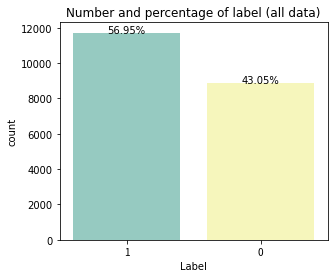

In [27]:
plot_count('Label', 'label (all data)', df=data_df,size=1.2)

## Cut phrases in ideograms groups

Chinese does not have flexionary forms and also does not use spaces between ideograms to mark separate words. In the same time, some concepts are using 2 ore more ideograms in a sequence. The reader will `cut` in mind during reading the sequences of ideograms in groups, corresponding to different concepts, based on context. 
We will use **jieba** library to separate the ideograms in groups.

In [28]:
def jieba_cut(x, sep=' '):
    return sep.join(jieba.cut(x, cut_all=False))

print('raw', data_df['Text'][0])
print('cut', jieba_cut(data_df['Text'][0], ', '))

Building prefix dict from the default dictionary ...


raw 接任欧盟轮值主席国 　葡萄牙担子不轻


Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.943 seconds.
Prefix dict has been built successfully.


cut 接任, 欧盟, 轮值, 主席国,  , 　, 葡萄牙, 担子, 不, 轻


We apply now the above defined function to the whole dataset. We are doing this for both the content and headline features.

In [29]:
%%time
data_df['headline_cut'] = Parallel(n_jobs=4)(
    delayed(jieba_cut)(x) for x in tqdm.tqdm_notebook(data_df['Text'].values)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20582 [00:00<?, ?it/s]

CPU times: user 1.13 s, sys: 82.2 ms, total: 1.21 s
Wall time: 6.29 s


In [30]:
prop = fm.FontProperties(fname=font_path, size=20)

After we cut the ideograms sequences in groups (each corresponding to one concept - or token) we represent the most frequenty used with wordclouds.

In [31]:

stopwords = set(STOPWORDS)

def show_wordcloud(data, font_path=font_path, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        font_path=font_path,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        prop = fm.FontProperties(fname=font_path)
        fig.suptitle(title, fontsize=40, fontproperties=prop)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

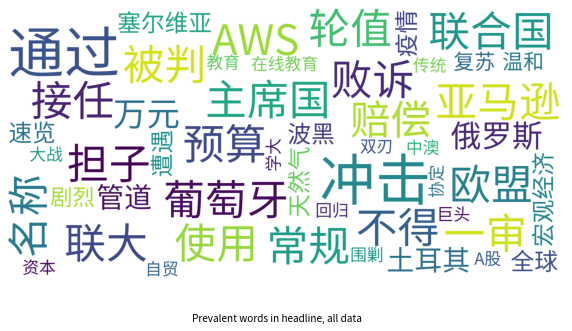

In [32]:
show_wordcloud(data_df['headline_cut'], font_path, title = 'Prevalent words in headline, all data')

We show now the most frequent groups of ideograms grouped by target value (or tag).

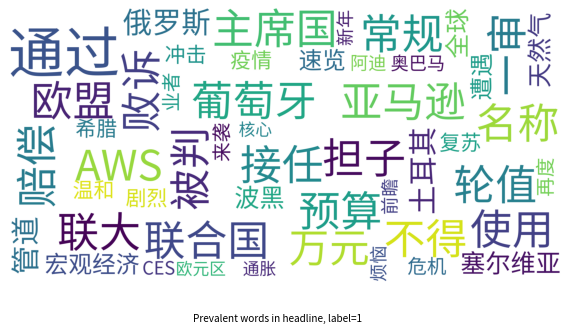

In [33]:
data_tag_df = data_df.loc[data_df.Label==1]
show_wordcloud(data_tag_df['headline_cut'], font_path, title = 'Prevalent words in headline, label=1')

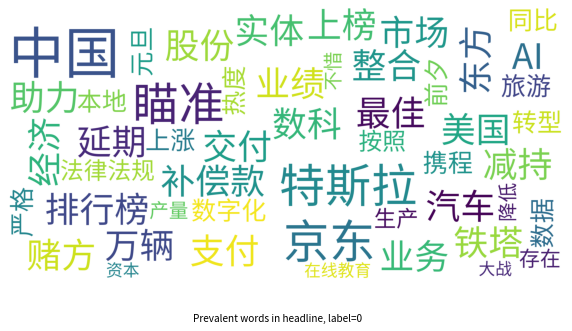

In [34]:
data_tag_df = data_df.loc[data_df.Label==0]
show_wordcloud(data_tag_df['headline_cut'], font_path, title = 'Prevalent words in headline, label=0')

# Split data to train-test

In [35]:
train_df, test_df = train_test_split(data_df, test_size = 0.2, random_state = 42) 

In [36]:
print(f"train: {train_df.shape}, test: {test_df.shape}")

train: (16465, 3), test: (4117, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


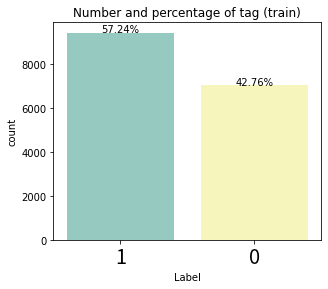

In [37]:
plot_count('Label', 'tag (train)', font_prop=prop, df=train_df,size=1.2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


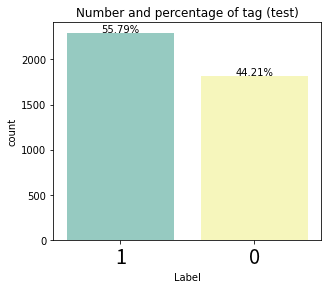

In [38]:
plot_count('Label', 'tag (test)', font_prop=prop, df=test_df,size=1.2)

# Text preprocessing

In [39]:
train_df.head()

,Text,Label,headline_cut
15395,1110家公司披露半年报业绩预告 近八成预喜,0,1110 家 公司 披露 半年报 业绩 预告 近 八成 预喜
18383,国务院会议通过“十三五”国家科技创新专项规划,0,国务院 会议 通过 “ 十三 五 ” 国家 科技 创新 专项规划
5222,比尔·盖茨：有关中美“脱钩”的声音让我很担忧,0,比尔 · 盖茨 ： 有关 中 美 “ 脱钩 ” 的 声音 让 我 很 担忧
7809,感到天热了吗？中东夏季发电用油高峰来临 油市供应趋紧或加剧,1,感到 天热 了 吗 ？ 中东 夏季 发电 用油 高峰 来临 油市 供应 趋紧 或 加剧
16159,沙特阿美终止与壳牌在美合作,1,沙特 阿美 终止 与 壳牌 在 美 合作


In [40]:
def count_vect_feature(feature, df, max_features=5000):
    start_time = time.time()
    cv = CountVectorizer(max_features=max_features,
                             ngram_range=(1, 1),
                             stop_words='english')
    X_feature = cv.fit_transform(df[feature])
    print('Count Vectorizer `{}` completed in {} sec.'.format(feature, round(time.time() - start_time,2)))
    return X_feature, cv

In [41]:
X_headline, cv = count_vect_feature('headline_cut', train_df, 20000)

Count Vectorizer `headline_cut` completed in 0.22 sec.


# Model

In [42]:
target =  'Label'
X = X_headline
y = train_df[target].values
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = 42) 

In [43]:
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((13172, 20000), (3293, 20000), (13172,), (3293,))

## SVC Model


We use first a SVC model (with linear kernel).


### Model fit

In [44]:
%%time
clf_svc = SVC(kernel='linear')
clf_svc = clf_svc.fit(train_X, train_y)

CPU times: user 50.7 s, sys: 181 ms, total: 50.9 s
Wall time: 50.8 s


### Model validation

In [45]:
def show_confusion_matrix(valid_y, predicted, size=1, font_prop=prop, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    f, ax = plt.subplots(1,1, figsize=(4*size,4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop);
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

Valid:
Feature: Label 	| Prediction accuracy: 0.5387184937746735
Feature: Label 	| Prediction F1-score: 0.5333784690883614
Feature: Label 	| Prediction recall: 0.5387184937746735


<Figure size 432x432 with 0 Axes>

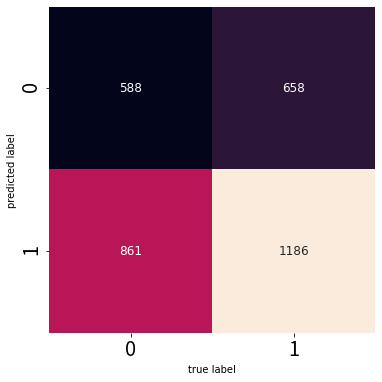

              precision    recall  f1-score   support

           0       0.47      0.41      0.44      1449
           1       0.58      0.64      0.61      1844

    accuracy                           0.54      3293
   macro avg       0.53      0.52      0.52      3293
weighted avg       0.53      0.54      0.53      3293



In [46]:
predicted_valid = clf_svc.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

## MultinomialNB model

In [47]:
%%time
clf_nb = MultinomialNB(fit_prior='true')
clf_nb = clf_nb.fit(train_X, train_y)

CPU times: user 5.03 ms, sys: 979 µs, total: 6.01 ms
Wall time: 5.82 ms


Valid:
Feature: Label 	| Prediction accuracy: 0.5463103552991193
Feature: Label 	| Prediction F1-score: 0.5358861206130634
Feature: Label 	| Prediction recall: 0.5463103552991193


<Figure size 432x432 with 0 Axes>

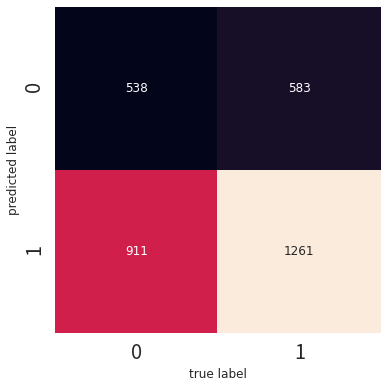

              precision    recall  f1-score   support

           0       0.48      0.37      0.42      1449
           1       0.58      0.68      0.63      1844

    accuracy                           0.55      3293
   macro avg       0.53      0.53      0.52      3293
weighted avg       0.54      0.55      0.54      3293



In [48]:
predicted_valid = clf_nb.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))